# Phase 1: Setup and Definition

In [1]:
import os
import cv2  # OpenCV for image processing
import numpy as np
import pandas as pd
from tqdm import tqdm  # Progress bar
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def load_data(data_dir, target_size=(64, 64)):
    """
    Loads images from folders, resizes them, and flattens them into 1D vectors.
    """
    features = []
    labels = []
    
    # Get the list of classes (folders)
    valid_classes = os.listdir(data_dir)
    print(f"Found {len(valid_classes)} classes. Ready to load.")

    for class_name in tqdm(valid_classes):
        class_path = os.path.join(data_dir, class_name)
        
        if not os.path.isdir(class_path):
            continue
            
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            
            try:
                img = cv2.imread(img_path)
                if img is None:
                    continue
                
                # Resize and Flatten
                img_resized = cv2.resize(img, target_size)
                img_flat = img_resized.flatten()
                
                features.append(img_flat)
                labels.append(class_name)
                
            except Exception as e:
                print(f"Error loading {img_name}: {e}")

    return np.array(features), np.array(labels)

# Phase 2: Data Loading (The Heavy Lift)

In [2]:
# Define path
dataset_path = '/kaggle/input/plantvillage-dataset/color'

# Load Data
print("Loading Data... (This will take time)")
X, y = load_data(dataset_path, target_size=(64, 64))

# Verification
print("-" * 30)
print("Data Loaded Successfully.")
print(f"Feature Matrix (X) Shape: {X.shape}")
print(f"Labels Vector (y) Shape: {y.shape}")
print("-" * 30)

Loading Data... (This will take time)
Found 38 classes. Ready to load.


100%|██████████| 38/38 [07:54<00:00, 12.50s/it]


------------------------------
Data Loaded Successfully.
Feature Matrix (X) Shape: (54305, 12288)
Labels Vector (y) Shape: (54305,)
------------------------------


# Phase 3: Preprocessing (Split & Scale)

In [3]:
# 1. Split Data (80% Train, 20% Test)
print("Splitting data into Train and Test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Scale Data
# This calculates the mean and variance of the training set
# and applies it to both train and test.
print("Scaling data (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Preprocessing complete.")

Splitting data into Train and Test sets...
Scaling data (StandardScaler)...
Preprocessing complete.


# Phase 4: Model Benchmarking

Starting Benchmarking on 3 safe models...
Restricting tree depth to save RAM.

⏳ Training Dummy Classifier...
Accuracy: 0.1058  | Time: 0.06s

⏳ Training Nearest Centroid...
Accuracy: 0.3760  | Time: 9.40s

⏳ Training Random Forest...
Accuracy: 0.6695  | Time: 328.14s
   -> Plotting Confusion Matrix...


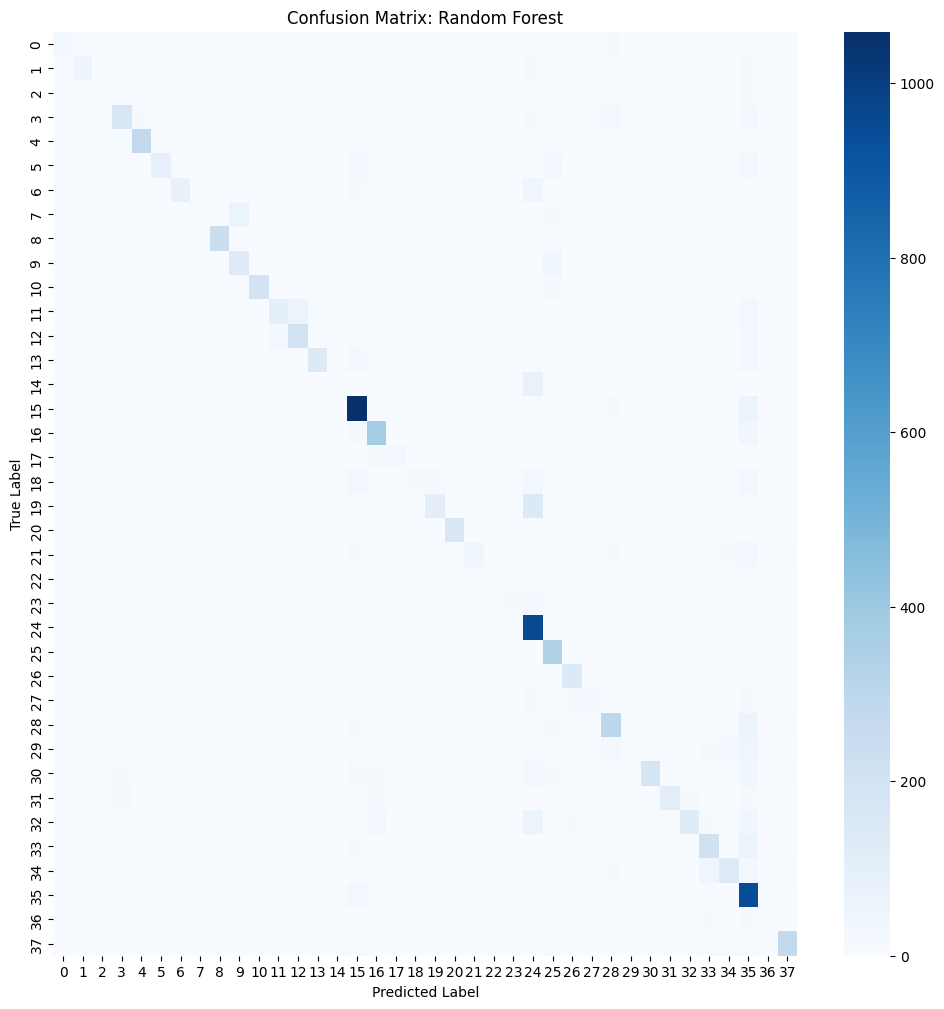


FINAL LEADERBOARD
1. Random Forest                  : 0.6695
2. Nearest Centroid               : 0.3760
3. Dummy Classifier               : 0.1058


In [4]:
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc # Garbage Collector to manually free RAM

# Define the dictionary of models
# selected for Low Memory usage and maximum stability
models = {
    # 1. The Floor (Zero Skill)
    # Answers: "What if I just guess the most common disease?"
    "Dummy Classifier": DummyClassifier(strategy="most_frequent"),
    
    # 2. Geometric Baseline (Super Fast)
    # Answers: "What if I just look at the 'average' image of a disease?"
    # Very lightweight, will not crash RAM.
    "Nearest Centroid": NearestCentroid(),
    
    # 3. Random Forest (SAFE MODE)
    # Answers: "How well can a powerful ensemble do?"
    # max_depth=20: Prevents trees from growing infinite and eating RAM.
    # n_jobs=2: Prevents CPU choking.
    "Random Forest": RandomForestClassifier(
        n_estimators=100, 
        max_depth=20,       # SAFETY LOCK
        n_jobs=2,           # SAFETY LOCK
        random_state=42
    )
}

results = {}

print(f"Starting Benchmarking on {len(models)} safe models...")
print("Restricting tree depth to save RAM.")
print("=" * 60)

for name, model in models.items():
    print(f"\n⏳ Training {name}...")
    start_time = time.time()
    
    try:
        # Train
        model.fit(X_train_scaled, y_train)
        
        # Predict
        y_pred = model.predict(X_test_scaled)
        
        # Calculate Metrics
        acc = accuracy_score(y_test, y_pred)
        elapsed = time.time() - start_time
        
        results[name] = acc
        
        print(f"Accuracy: {acc:.4f}  | Time: {elapsed:.2f}s")
        
        # Plot Confusion Matrix only for the Random Forest (The main event)
        if name == "Random Forest":
            print(f"   -> Plotting Confusion Matrix...")
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(12, 12))
            sns.heatmap(cm, annot=False, fmt='d', cmap='Blues')
            plt.title(f"Confusion Matrix: {name}")
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
    except Exception as e:
        print(f"❌ Model Failed: {e}")
        results[name] = 0.0
    
    # FORCE CLEANUP: Manually free memory after every model
    gc.collect() 

print("\n" + "=" * 60)
print("FINAL LEADERBOARD")
print("=" * 60)
sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

for rank, (name, acc) in enumerate(sorted_results, 1):
    print(f"{rank}. {name:<30} : {acc:.4f}")